# Finding Centroids
This notebook is a follow up of the notebook ilastik/pixels_classification_multiple_channels
We segment our images using the probability images obtained by ilastik and find the centroids of our objects.

## Goal of the analysis
We have a number of images from a confocal microscope containing 4 channels (DAPI, 488, 561 and 642). 

## Prepare the analysis
First, we need to import the libraries that we are going to use

In [1]:
import os
import pickle
import numpy as np
from skimage.filters import threshold_otsu, apply_hysteresis_threshold
from skimage.segmentation import clear_border
from skimage.morphology import closing
from skimage.measure import label, regionprops
from scipy.spatial.distance import cdist
from itertools import permutations

import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
from getpass import getpass
import subprocess
import omero_toolbox as omero

... and define or request a number of variables that we are going to use in the analysis

In [2]:
# the ID if the dataset containing th raw images and the probability images
RAW_DATASET_ID = input("Dataset ID: ")

# The name of the group where the data is stored
GROUP = input("Group name: ")  # the group where the data is stored

# the URL and port of our OMERO server
OMERO_SERVER = 'omero.mri.cnrs.fr'
# the port to connect to. Default is 4046
PORT = 4064

# Create a connection
conn = omero.open_connection(username=input('OMERO username:'), password=getpass('OMERO password:'),
                               group=GROUP, host=OMERO_SERVER, port=PORT, secure=True)
print(f'Connection successful: {conn.isConnected()}')

# a directory to save temporary files
TEMP_DIR = '/run/media/julio/DATA/Quentin/temp'
# the path to the ilastik executable
ILASTIK_PATH = '/home/julio/Apps/ilastik-1.3.3post3-Linux/run_ilastik.sh'

Dataset ID: 14855
Group name: MRI-IGH
OMERO username:mateos
OMERO password:········
Connection successful: True


### Explore your data
Now we can connect to OMERO, get some information on the dataset that we want to analyze and explore the data.

In [3]:
# Get all the images contained in the raw dataset
raw_dataset = omero.get_dataset(connection=conn, dataset_id=RAW_DATASET_ID)
raw_images = omero.get_dataset_images(dataset=raw_dataset)
raw_images = list(raw_images)

print('RAW IMAGES')
for image in raw_images:
    print(f'{image.getName()} Dimensions(z, c, t, x, y): {image.getSizeZ()}, {image.getSizeC()}, {image.getSizeT()}, {image.getSizeX()}, {image.getSizeY()}')


RAW IMAGES
20181012_S2Rplus_FISH_DAPI_X1-A488_X2-A555_X3-A647.lif [Mark_and_Find_001/Position001] Dimensions(z, c, t, x, y): 30, 4, 1, 1576, 1576
20181012_S2Rplus_FISH_DAPI_X1-A488_X2-A555_X3-A647.lif [Mark_and_Find_001/Position002] Dimensions(z, c, t, x, y): 30, 4, 1, 1576, 1576
20181012_S2Rplus_FISH_DAPI_X1-A488_X2-A555_X3-A647.lif [Mark_and_Find_001/Position003] Dimensions(z, c, t, x, y): 30, 4, 1, 1576, 1576
20181012_S2Rplus_FISH_DAPI_X1-A488_X2-A555_X3-A647.lif [Mark_and_Find_001/Position004] Dimensions(z, c, t, x, y): 30, 4, 1, 1576, 1576
20181012_S2Rplus_FISH_DAPI_X1-A488_X2-A555_X3-A647.lif [Mark_and_Find_001/Position005] Dimensions(z, c, t, x, y): 30, 4, 1, 1576, 1576
20181012_S2Rplus_FISH_DAPI_X1-A488_X2-A555_X3-A647.lif [Mark_and_Find_001/Position006] Dimensions(z, c, t, x, y): 30, 4, 1, 1576, 1576
20181012_S2Rplus_FISH_DAPI_X1-A488_X2-A555_X3-A647.lif [Mark_and_Find_001/Position007] Dimensions(z, c, t, x, y): 30, 4, 1, 1576, 1576
20181012_S2Rplus_FISH_DAPI_X1-A488_X2-A555_X

You should see a few of the raw images: 3-D stacks of 4 channels (DAPI, X1, X2 and X3) and

### Exploring the raw values
You may load a part of an image as a **_Numpy ndarray_** (n-dimensional array). 
This is Python's way to work very efficient with numeric matrices, and that is what an image is.

In [4]:
# you may use the 'range' optional parameters to get a specified plane or channel or a range (start_included, stop_not_included)
raw_data = omero.get_intensities(raw_images[0],
                                 z_range=(14, 17),  # requests planes 16 and 17 if you start counting with 1
                                 c_range=0)  # This is the DAPI channel

You may now see the dimensions, ...

In [5]:
# The dimensions are stored in the following order (z, c, t, x, y)
print(raw_data.shape)

(3, 1, 1, 1576, 1576)


... data type and raw values.

In [6]:
print(raw_data.dtype)
print(raw_data[0,           # the first plane 15. Note again the 0 based indexing.
               0,           
               0,           # time point 0
               1100:1120,   # x pixels in the format from:until_but_excluded
               90:100]      # for example from pixel 90 until pixel 100 (the pixel at position 100 is excluded)
      )

uint16
[[647 295 606 343 371 495  67 486 970 413]
 [ 87 511 382 677 505 456 180 346 330 364]
 [359 523 423 435  88  72  82 221   2 125]
 [222 140  68 321   0 196 153 295  48  79]
 [455 256 246   1  23 145   3  54 276 372]
 [157  23 174 186  54 417  47  18 100   4]
 [378 308 151 256   2 219   0   3  69 157]
 [ 56 210 247 140  39   3   3   4  97   2]
 [300   2   2  82 106 115 174  26   3   2]
 [ 31   1  36   5   1   3  75   3   3   3]
 [ 31  82  39   2  73  44 126 116 104   3]
 [  4 198   4   7 100   2   3   3   3   3]
 [106  31   4   1  18 238   2   3   4  61]
 [ 16 135   4  26  45   3   2   3   4   2]
 [  4   1 104   3  39   3   3   3 107   3]
 [  4  47   2   2   2   8 134   3   4   2]
 [ 27   1   4  69   4   6   2   2  26   1]
 [  2   4   4   8   3  15   4   3   4   3]
 [ 43  15  45  28  52   4   2   3   2   1]
 [ 37  76   5 101   4   1   5  52   3   4]]


### Visualizing Numpy arrays
You may have a more convenient visualization of these data by using any of the python plotting libraries.
Python's standard library includes matplotlib. We imported previously *matplotlib.pyplot* as *plt* so let's use it.

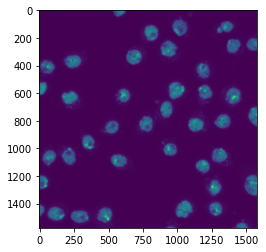

In [7]:
# We create a plot of the image, a Max Intensity Projection for example
MIP = raw_data.max(axis=0)  # specify the axis you want to use for the projection (c=0)
plt.imshow(MIP.squeeze())  # Squeeze is removing all dimensions with size 1, they are not very useful

# Creating the plot just creates it but you always have to show it
plt.show()

matplotlib may create very complex publication-ready plots. You may have a look at what you may do in [here](https://matplotlib.org/gallery.html).

## Running the analysis
Before moving further we have to create a number of functions that are going to help us to simplify the logic of the analysis.

In [8]:
def run_ilastik(ilastik_path, input_path, model_path):
    """Run ilastik in a separate process in a synchronous way
    """
    cmd = [ilastik_path,
           '--headless',
           f'--project={model_path}',
           '--export_source=Probabilities',
           '--output_format=numpy',
           '--output_filename_format={dataset_dir}/{nickname}_Probabilities.npy',
           '--export_dtype=uint8',
           '--output_axis_order=zctyx',
           input_path]
    try:
        subprocess.run(cmd, check=True, stdout=subprocess.PIPE).stdout
    except subprocess.CalledProcessError as e:
        print(f'Input command: {cmd}')
        print()
        print(f'Error: {e.output}')
        print()
        print(f'Command: {e.cmd}')
        print()

def load_models(dataset_id, path):
    """Downloads the model files associated to a dataset and returns a list with the paths
    """
    dataset = conn.getObject("Dataset", dataset_id)
    file_paths = []
    # Go through all the annotations on the Dataset
    for ann in dataset.listAnnotations():
        if isinstance(ann, omero.gw.FileAnnotationWrapper):
            name = ann.getFile().getName()
            # Select the ilastik project TODO: use namespace
            if name.endswith(".ilp"):
                file_path = os.path.join(path, name)
                with open(str(file_path), 'wb') as f:
                    for chunk in ann.getFileInChunks():
                        f.write(chunk)
                file_paths.append(file_path)
    file_paths.sort()
    return file_paths

def segment_channel(channel, threshold=None, remove_border=False, low_corr_factor=1, high_corr_factor=1):
    """Segment a channel (3D numpy array)
    """
    if threshold is None:
        threshold = threshold_otsu(channel)

    thresholded = apply_hysteresis_threshold(channel,
                                             low=threshold * low_corr_factor,
                                             high=threshold * high_corr_factor
                                             )

    thresholded = closing(thresholded)
    if remove_border:
        thresholded = clear_border(thresholded)
    return label(thresholded)

def segment_image(image,
                  thresholds=None,
                  low_corr_factors=None,
                  high_corr_factors=None):
    """Segment an image and return a labels object.
    Image must be provided as zcyx numpy array
    """
    if low_corr_factors is None:
        low_corr_factors = [.95] * image.shape[1]
    if high_corr_factors is None:
        high_corr_factors = [1.05] * image.shape[1]

    if len(high_corr_factors) != image.shape[1] or len(low_corr_factors) != image.shape[1]:
        raise Exception('The number of correction factors does not match the number of channels.')

    # We create an empty array to store the output
    labels_image = np.zeros_like(image, dtype=np.uint16)
    for c in range(image.shape[1]):
        threshold = thresholds[c] if thresholds is not None else None
        labels_image[:, c, ...] = segment_channel(image[:, c, ...],
                                                  threshold=threshold,
                                                  low_corr_factor=low_corr_factors[c],
                                                  high_corr_factor=high_corr_factors[c])
    return labels_image

def compute_channel_spots_properties(channel, label_channel):
    """Analyzes and extracts the properties of a single channel"""

    ch_properties = []

    regions = regionprops(label_channel, channel)

    for region in regions:
        ch_properties.append({'label': region.label,
                              'area': region.area,
                              # XY coordinates are swapped in a numpy array compared to an image
                              'centroid': (region.centroid[0], region.centroid[1], region.centroid[1]),
                              'weighted_centroid': (region.weighted_centroid[0], region.weighted_centroid[2], region.weighted_centroid[1]),
                              'max_intensity': region.max_intensity,
                              'mean_intensity': region.mean_intensity,
                              'min_intensity': region.min_intensity
                              })

    return ch_properties

def compute_distances_matrix(positions, sigma, pixel_size=None, remove_mcn=False):
    """Calculates Mutual Closest Neighbour distances between all channels and returns the values as
    a list of tuples where the first element is a tuple with the channel combination (ch_A, ch_B) and the second is
    a list of pairwise measurements where, for every spot s in ch_A:
    - Positions of s (s_x, s_y, s_z)
    - Weighted euclidean distance dst to the nearest spot in ch_B, t
    - Index t_index of the nearest spot in ch_B
    Like so:
    [((ch_A, ch_B), [[(s_x, s_y, s_z), dst, t_index],...]),...]
    """
    # TODO: Correct documentation
    # Container for results
    distances = []

    if len(positions) < 2:
        raise Exception('Not enough dimensions to do a distance measurement')

    channel_permutations = list(permutations(range(len(positions)), 2))

    # Create a space to hold the distances. For every channel permutation (a, b) we want to store:
    # Coordinates of a
    # Distance to the closest spot in b
    # Index of the nearest spot in b

    if not pixel_size:
        pixel_size = np.array((1, 1, 1))
        # TODO: log warning
    else:
        pixel_size = np.array(pixel_size)

    for a, b in channel_permutations:
        # TODO: Try this
        # TODO: Make explicit arguments of cdist
        distances_matrix = cdist(positions[a], positions[b], w=pixel_size)

        pairwise_distances = {'channels': (a, b),
                              'coord_A': list(),
                              'dist_3d': list(),
                              'index_A': list(),
                              'index_B': list()
                              }
        for index_a, (p, d) in enumerate(zip(positions[a], distances_matrix)):
            if d.min() < sigma:
                # We remove the mutual closest neighbours
                if remove_mcn and distances_matrix[:, d.argmin()].argmin() != index_a:
                    continue
                else:
                    pairwise_distances['coord_A'].append(tuple(p))
                    pairwise_distances['dist_3d'].append(d.min())
                    pairwise_distances['index_A'].append(index_a)
                    pairwise_distances['index_B'].append(d.argmin())

        distances.append(pairwise_distances)

    return distances

def run_image_analysis(raw_data, prob_data, pixel_size, size_thresholds, thresholds=None,
                       up_threshold_corrections=None, low_threshold_corrections=None, min_distance=None):
    """This function encapsulates our analysis of a single OMERO image"""

    # We create an empty lists to store the different measurements of the spots
    spots_props = []

    # We segment the probabilities images
    labels = segment_image(image=prob_data.squeeze(), thresholds=thresholds,
                           low_corr_factors=low_threshold_corrections,
                           high_corr_factors=up_threshold_corrections)

    # The labels object contains now the segmentation masks for every found object
    # We use it to calculate the properties of every object using the raw data:
    for ch in range(labels.shape[1])[1:]:  # with this notation here we skip the DAPI channel in position 0

        spots_props_channel = compute_channel_spots_properties(channel=raw_data[:, ch, ...].squeeze(),
                                                               label_channel=labels[:, ch, ...])

        # We can filter out the spots that are too small
        for i in reversed(range(len(spots_props_channel))):
            if spots_props_channel[i]['area'] < size_thresholds[ch - 1]:
                del spots_props_channel[i]

        # We append the spots properties and positions to the lists containing the image measurements
        spots_props.append(spots_props_channel)

    # We have all the information collected for every channel we can now apply a function to measure the pairwise distances between the spots
    spots_pos = [np.array([x['weighted_centroid'] for x in p]) for p in spots_props]

    pairwise_distances = compute_distances_matrix(positions=spots_pos,
                                                  sigma=min_distance,  # this marks a threshold for the distances that are going to be accepted
                                                  pixel_size=pixel_size,
                                                  remove_mcn=True)
    return pairwise_distances

def clean_image_name(image_name):
    """Cleans the odd naming of lif files"""
    filename, file_extension = os.path.splitext(image_name)
    filename = filename.replace('/', '_')
    filename = filename.replace('.lif [', '_')
    filename = filename.replace(']', '')

    return filename


We want to get the models that have been previously trained to clasify the pixels of our images.
Each model is supposed to be used on a channel of combination of channels adn we want to tell our scipt how.

In [9]:
model_files = load_models(RAW_DATASET_ID, TEMP_DIR)
model_to_channels = {}
for file in model_files:
    print(file)
    model_to_channels[file] = eval(input('Channels affected in the right order and separated by: '))

/run/media/julio/DATA/Quentin/temp/Ch0_model.ilp
Channels affected in the right order and separated by: 0
/run/media/julio/DATA/Quentin/temp/Ch1_model.ilp
Channels affected in the right order and separated by: 0,1
/run/media/julio/DATA/Quentin/temp/Ch2_model.ilp
Channels affected in the right order and separated by: 0,2
/run/media/julio/DATA/Quentin/temp/Ch3_model.ilp
Channels affected in the right order and separated by: 0,3


## Analyzing the images
Now we have everything ready to start our image analysis. We want to:
- Analyze each image using the pretrained model to obtain images representing the probabilities of a pixel to belong to a object type
- Store those images into a separate dataset named '_PROB'
- Segment each channel using the probability values extracted by Ilastik instead of the raw values.
- Save that segmentation into OMERO.
- While we still have the images in memory, we would like to calculate the centroids of the spots this time 
using the raw pixel values.
- We will save the centroid coordinates as a table associated to every image.

For most of the image analysis we are going to use scikit-image, a python image analysis library built on top of numpy.
We will have to fix, for each channel:
 - an upper threshold marking what is going to be defined as an object
 - a lower threshold marking until what probability the object is going to segment

### Running the analysis
Now we have created a function we can apply it to every image in the dataset and collect the results.

Note that this analysis might be more or less slow depending on:
- the speed of the connection between the OMERO and Jupyter servers and
- the CPU specs associated to the Jupyter python kernel.

However, this is not how you are going to analyze large amounts of data. Typically, you are going to deploy the execution of the most demanding tasks to either:
- different execution threads (for example, one thread reading the data from OMERO and another thread doing the calculations)
- different CPU processes (for heavier calculations)
- a HPC cluster (for even heavier calculations)
- or to the GPU (for heavy calculations that can take advantage of these, for example when implementing deep learning)

In [10]:
# Let's fix the probability hysteresis thresholds at which we want to segment.
# There will be an upper threshold and a lower threshold per channel.
thresholds = (220, 220, 220, 220)
up_threshold_corrections = (1.1, 1.1, 1.1, 1.1)
low_threshold_corrections = (0.8, 0.8, 0.8, 0.8)

# We are going to use a size filter to remove the objects that are too small
size_thresholds = (500, 500, 500)

# We should define a minimum distance threshold, in the same units as the data
min_distance = 100

# A list to contain all of the distances
pairwise_distances_dataset = []

# We create here a small widget to follow the progress
progress = widgets.IntProgress(value=0, min=0, max=len(raw_images), description='Progress: ')
display(progress)

# Let's create a new dataset in OMERO to store the probability images
prob_dataset = omero.create_dataset(connection=conn,
                                    name=f'{raw_dataset.getName()}_PROB',
                                    description=f'Source dataset id: {raw_dataset.getId()}',
                                    parent_project=raw_dataset.getParent())

# Let's loop through our images
for raw_image in raw_images:
    raw_data = omero.get_intensities(raw_image)
    prob_data = np.zeros_like(raw_data, dtype='uint8')
    for out_channel, (model, in_channels) in enumerate(model_to_channels.items()):
        input_file = os.path.join(TEMP_DIR, f'{in_channels}')
        np.save(input_file, raw_data[:,in_channels,...])
        run_ilastik(ILASTIK_PATH, f'{input_file}.npy', model)
        ilastik_output = np.load(f'{input_file}_Probabilities.npy')
        prob_data[:,out_channel,...] = ilastik_output[:,0,...]

    omero.create_image_from_numpy_array(connection=conn,
                                        data=prob_data,
                                        image_name=clean_image_name(raw_image.getName()),
                                        image_description=f'Source image id: {raw_image.getId()}',
                                        dataset=prob_dataset,
                                        source_image_id=raw_image.getId(),
                                        )

    # We need the pixel sizes
    pixel_size = omero.get_pixel_size(raw_image)

    calculated_distances = run_image_analysis(raw_data=raw_data,
                                              prob_data=prob_data,
                                              pixel_size=pixel_size,
                                              size_thresholds=size_thresholds,
                                              up_threshold_corrections=up_threshold_corrections,
                                              low_threshold_corrections=low_threshold_corrections,
                                              min_distance=min_distance)

    pairwise_distances_dataset.append(calculated_distances)

    # Update the progress bar
    progress.value += 1

# Save the data temporarily
with open(os.path.join(TEMP_DIR, 'data.pkl'), 'wb') as output:
    pickle.dump(pairwise_distances_dataset, output, pickle.HIGHEST_PROTOCOL)

IntProgress(value=0, description='Progress: ', max=12)

Now we have a rather complex list of lists of dictionaries containing all the relevant data. 
For every combination of channels a and b we know:
- the id of the spot in channel a
- the 3D coordinates of the centroid of that spot (z, x and y)
- the 3D distance to the closest spot in channel b
- the id of the closest spot in channel b

Here is how the data is arranged:
- list: [image0, image1, image2...]
    - list: [ch_1 vs ch_2, ch_1 vs ch_2, ch_2 vs ch_1,...]
        - dictionary: {channels, coord_A, dist_3d, index_A, index_B}

We can request some of these data. For example for image 1 and channels 2 and 3

In [11]:
image_nr = 0
channels = (1, 2)

print('A_ID\tB_ID\tA_xyz_coord\t\t\tAB_distance_3D')
for distances in pairwise_distances_dataset[image_nr]:
    if distances['channels'] == channels:
        for coord_A, dist_3d, index_A, index_B in zip(distances['coord_A'], 
                                                      distances['dist_3d'], 
                                                      distances['index_A'], 
                                                      distances['index_B']):
            print(f'{index_A}\t{index_B}\t{coord_A[1]:.4f}, {coord_A[2]:.4f}, {coord_A[0]:.4f}\t{dist_3d}')
        break

A_ID	B_ID	A_xyz_coord			AB_distance_3D
0	0	672.3841, 318.9275, 9.6626	1.4458856743672577
5	5	1048.2813, 1488.6058, 14.2933	2.3404081120121534
6	4	1567.6281, 803.5909, 16.6427	2.1600176033571814
7	10	992.5460, 266.3971, 17.6948	1.2329977994700803
9	14	1404.6303, 583.4292, 19.6875	1.1334670624392456
10	19	14.9931, 1262.3858, 19.9200	2.568453691840044
11	16	610.9862, 616.1754, 19.4468	0.43012779791524636
12	21	994.1888, 575.5022, 22.8372	2.943252891334705
13	23	831.0512, 179.7722, 25.7045	2.444479903424946
14	20	147.7992, 1441.4448, 21.9920	3.635013950601564
15	24	957.6302, 726.4540, 26.1505	2.2917846846083227
16	26	1151.6762, 815.9627, 26.8263	1.6298750322622046


## Storing the data back into OMERO
We have all the data now, and we can store them back into OMERO

### Storing the spots as ROIs
We can, for example save every spot as a point ROI associated to the image

In [12]:
for distances, raw_image in zip(pairwise_distances_dataset, raw_images):
    
    # We loop over every distance pair, create a 'point shape' and add it to the list
    for distance_pair in distances:

        # We create an empty list to put all the points
        point_shapes = list()

        for (z, x, y), id_a in zip(distance_pair['coord_A'], distance_pair['index_A']):
            point = omero.create_shape_point(x_pos=x,
                                             y_pos=y,
                                             z_pos=int(z) - 1,  # z position must be entered as an integer
                                             t_pos=0,
                                             name=f'Ch:{1 + distance_pair["channels"][0]}_id:{id_a}')
            point_shapes.append(point)

        # We create a ROI containing all of these points. Alternatively, we could create a ROI per point.
        roi = omero.create_roi(connection=conn,
                               image=raw_image,
                               shapes=point_shapes)

### Storing data as a table
You may store large amounts of data in *_OMERO.tables_*. Let's store the distances as a table.

First we have to extract the data properly. We will need:
- A list with the column names
- A list with the column descriptions (optional).
- A list of columns where every column is a list with the values

We will store:
- Channel (a) where the spot is located
- Channel (b) where the closest spot is located
- Coordinates of the spot
- Units of the coordinates
- 3D-distance to the closest spot
- Units of the Distance

In [13]:
# We create the list with the column names
col_names = ['image_id',
             'channel_a', 
             'channel_b', 
             'coord_z',
             'coord_x',
             'coord_y',
             'coord_units',  # Measurement make no sense without the units
             'mcn_dist_3d',
             'mcn_dist_3d_units',
             ]

# We create the list with the column names
col_desc = ['ID of the image',
            'Channel where the spot is located', 
            'Channel where the mutual closest neighbour spot is located', 
            'Z position of the weighted centroid of the spot',
            'X position of the weighted centroid of the spot',
            'Y position of the weighted centroid of the spot',
            'Position units',
            '3D distance to the mutual closes neighbour (MCN)',
            '3D MCN distance units',
            ]

# We create a list of lists to hold the data
col_data = [list() for e in col_names]

# Let's loop through distances and images to populate the data in th column
for raw_image, distances in zip(raw_images, pairwise_distances_dataset):
    for distance_pair in distances:
        for i in range(len(distance_pair['dist_3d'])):
            col_data[0].append(raw_image.getId())
            col_data[1].append(1 + distance_pair['channels'][0])
            col_data[2].append(1 + distance_pair['channels'][1])
            col_data[3].append(distance_pair['coord_A'][i][0].item())
            col_data[4].append(distance_pair['coord_A'][i][1].item())
            col_data[5].append(distance_pair['coord_A'][i][2].item())
            col_data[6].append('PIXEL')
            col_data[7].append(distance_pair['dist_3d'][i].item())
            # Note that OMERO provides the pixel size units for each axis. We assume here that the unit is the same for each axis
            col_data[8].append(omero.get_pixel_size_units(raw_image)[0])

Now we are ready to save this table to OMERO and link it to the original dataset

In [14]:
OMERO_table = omero.create_annotation_table(connection=conn,
                                            table_name='Distances_table_V1',
                                            column_names=col_names,
                                            column_descriptions=col_desc,
                                            values=col_data)

omero.link_annotation(raw_dataset, OMERO_table)

TypeError: Could not detect column datatype for column coord_z

## Closing the connection
Let's clean up after our selves

In [15]:
# Closing the connection to OMERO
conn.close()

# And verifying tha it closed
print(f'Connected? {conn.isConnected()}')


Connected? False
